# Model 1: (2 Leaky ReLU, 1 Softmax) Cross Entropy Loss

In [1]:
'Load the packages'

import h5py
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import timeit
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

'Import the data'

with h5py.File('train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('train_label.h5','r') as H:
    label = np.copy(H['label'])
with h5py.File('test_128.h5','r') as H:
    actual_test_data = np.copy(H['data'])
    
'Perform preprocessing' 

## Create a label list from the label array for prediction purposes
label_list = []
for i in label:
    label_list.append(i)

## Create a label matrix for computational purposes
label_matrix = []
for i in label:
    vect = [0]*10
    vect[i] = 1
    label_matrix.append(vect)
label_matrix = np.array(label_matrix)

## Train test split
train_data , test_data = data[:42000,:], data[42000:,:]
train_label, test_label = label_matrix[:42000], label_matrix[42000:]
    
'Activation Functions'

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, x):
        # a = np.tanh(x)   
        return 1.0 - x**2
    
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, x):
        return  x * (1 - x)
    
    def __relu(self, x):
        return x * (x > 0)
    
    def __relu_deriv(self, x):
        return 1 * (x > 0)
    
    def __leaky_relu(self, x, alpha=0.01):
        return alpha * -1 * x * (x < 0) + x * (x > 0)
    
    def __leaky_relu_deriv(self, x, alpha=0.01):
        return alpha * (x < 0) + 1 * (x > 0)
    
    def __softmax(self,x):
        e = np.exp(x-np.max(x))  # Stable softmax
        if e.ndim == 1:
            return e / np.sum(e, axis=0) # Number of dimensions 1
        else:  
            return e / np.array([np.sum(e, axis=1)]).T 
    
    def __softmax_deriv(self,x):
        e = np.exp(x-np.max(x)) 
        return e/np.sum(e) - (e/np.sum(e))**2
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'leaky_relu':
            self.f = self.__leaky_relu
            self.f_deriv = self.__leaky_relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv  

'Hidden Layer Class'

class HiddenLayer(object):    
    def __init__(self,n_in, n_out, W=None, b=None, rng = None,
                 activation='tanh'):

        self.input=None
        self.activation=Activation(activation).f
        self.activation_deriv=Activation(activation).f_deriv
        
        ## Initialize attentuation constant for momentum
        global gamma
        gamma = 0.9
        
        ## Rng check for dropout
        if rng is None:
            self.rng = np.random.RandomState(1234)
        
        ## Initialize weights and bias
        self.W = np.random.normal(0, 1 ,(n_in,n_out))
        self.b = np.zeros(n_out,)       
        
        if activation == 'logistic':
            self.W *= 4
    
        # Initialize gradients of W, b     
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # Initialize momentum values
        self.momentum_W = 0
        self.momentum_b = 0
        self.momentum_g = 0
        self.momentum_v = 0
        
        # This value checks to see that the initialization of the weight norm process occurs only once
        self.first_pass = 0
        
    def forward(self, input):
 
        # Calculate linear output of initial feedforward pass
        lin_output = np.dot(input, self.W) + self.b   
        
        # If initialization hasn't occurred, do so once
        if self.first_pass == 0:
            
            # Calculate standard deviation and mean 
            std_lin_output = np.std(lin_output)
            mean_lin_output = np.mean(lin_output)
            
            # Calculate g, v and b for initial pass
            self.g = 1/std_lin_output
            self.v = np.random.normal(0, 1, self.W.shape)   
            self.b = -mean_lin_output/std_lin_output
            
            self.first_pass += 1
        
        # Calculate the norm of v
        v_norm = np.linalg.norm(self.v)
        
        # Reconstruct W
        self.W = self.g*self.v/v_norm   
        
        # Calculate new linear output
        new_lin_output = np.dot(input, self.W) + self.b
        self.output = (
            new_lin_output if self.activation is None
            else self.activation(new_lin_output)
        )    
        
        # Pass these values to next layer
        self.input=input
        return self.output
    
    def backward(self, delta):
        
        # Calculate the new gradients using momentum update
        
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) + gamma * self.momentum_W
        self.grad_b = np.sum(delta, axis = 0) + gamma * self.momentum_b
        v_norm = np.linalg.norm(self.v)
        self.grad_g = self.grad_W * self.v / v_norm + gamma * self.momentum_g
        self.grad_v = self.g * self.grad_W/v_norm - self.g*self.grad_g * self.v/(v_norm)**2 + gamma * self.momentum_v
        delta_ = (delta.dot(self.W.T) * self.activation_deriv(self.input))
        
        # Return delta_ for next layer
        return delta_
        
    def dropout(self, input, prob_dropout):

        dropout_mask = self.rng.binomial(size=input.shape,n=1, p=1-prob_dropout)
        return dropout_mask
    
'Multi-Layer Perceptron'
 
## Create a container for dropout    
dropout_masks = []      
    
class MLP:
    
    def __init__(self, layers,p_dropout=0.5, rng = None, activation='tanh'):

        ### initialize layers
        self.layers=[]
        self.params=[]
        dropout_masks = []
        
        if rng is None:
            rng = np.random.RandomState(1234)
        
        self.activation=activation
        
        for i in range(len(layers)-1):
            # Hidden to Output
            if (i % len(layers) - 2) == 0:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation='softmax'))
            # Hidden to Hidden
            elif (i % len(layers) - 1) == 0:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation='leaky_relu'))
            # Input to Hidden
            else:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation='leaky_relu'))
            
    def forward(self,input, dropout = False, p_dropout = 0.5):
        for i in range(len(self.layers)):
            output=self.layers[i].forward(input)
            input=output
            if dropout == True and i < len(self.layers)-1:
                mask = self.layers[i].dropout(input = output, prob_dropout = p_dropout)
                output *= mask
                dropout_masks.append(mask)
                input=output
            self.output = output
        return output
    
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation).f_deriv
        error = (y-y_hat)
        
        ## Cross entropy loss
        m = 1/y.shape[0]      
        loss = -m * np.sum(y * np.log(np.absolute(y_hat)))
        
        ## divide by mini batch size
        delta= (error/30)
        return loss,delta      
            
    def backward(self,delta, dropout = False, p_dropout = 0.5):        
        for i in reversed(range(len(self.layers))):
            delta= self.layers[i].backward(delta)
            if dropout == True:
                if i > 0:
                    delta *= dropout_masks[i-1]
        del dropout_masks[:]
            
    def update(self,lr):
        for layer in self.layers:
            
            # Calculate new momentums of W, b, g and v and update each parameter
            layer.momentum_W = layer.momentum_W * gamma + lr * layer.grad_W
            layer.momentum_b = layer.momentum_b * gamma + lr * layer.grad_b
            layer.momentum_g = layer.momentum_g * gamma + lr * layer.grad_g
            layer.momentum_v = layer.momentum_v * gamma + lr * layer.grad_v
            layer.W += layer.momentum_W
            layer.b += layer.momentum_b
            layer.g += layer.momentum_g
            layer.v += layer.momentum_v

    def fit(self,X,y,learning_rate=0.1,dropout = False, p_dropout = 0.5, batchsize = 30, rng = None, epochs=100):
        
        # Mini-batch size
        num_of_batches = train_data.shape[0]/batchsize
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            
            shuffled_train, shuffled_label = shuffle(train_data, train_label, random_state = 1)
            
            bXY = zip(np.array_split(shuffled_train, num_of_batches, axis = 0),
                      np.array_split(shuffled_label, num_of_batches, axis = 0))
            
            loss=np.zeros(X.shape[0])
            for bX, bY in bXY:
                
                # forward pass
                b_y_hat = self.forward(bX)
                
                # backward pass
                loss,delta=self.criterion_MSE(bY,b_y_hat)
                self.backward(delta)
                
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x, dropout = False,p_dropout = 0.5):
        x = np.array(x)        
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = np.argmax(nn.forward(x[i,:],dropout = False))
        return output
    
'Training the neural network'

## Training the neural network
nn = MLP([128,64,32,10], activation = 'tanh')

## Start of function runtime
model1_start_time = timeit.default_timer()

## Build the model
MSE = nn.fit(train_data, train_label, learning_rate=0.01,dropout = True, epochs=10)
print('Cross Entropy Loss:%f'%MSE[-1])

## End of function runtime
model1_end_time = timeit.default_timer()

## Runtime difference
model1_time_dif = (model1_end_time - model1_start_time)/60

## Print the time difference
print('Function Runtime:', np.round(model1_time_dif, 2), 'minutes')

'Print Test Results'

## Calculating predictions and overall accuracy over testing data
output = nn.predict(test_data, dropout = True)
print("Accuracy over test data for model 1 is",np.mean(output == label_list[42000:]))

## Plotting cross entropy loss over epochs
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()
pl.title("Cross Entropy loss over epochs for model 1")
pl.xlabel("Epochs")
pl.ylabel("Cross Entropy loss")

## Precision, recall and F-score by class (classification report)
model1_report = classification_report(label_list[42000:], output)
print(model1_report)

## Creating a confusion matrix
confusion_targets = pd.Series(label_list[42000:], name='Targets')
confusion_preds = pd.Series(output, name='Predictions')
model1_confusion = pd.crosstab(confusion_targets, confusion_preds)
print(model1_confusion)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:237: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:237: RuntimeWarning: invalid value encountered in multiply


Cross Entropy Loss:3.772648
Function Runtime: 0.2 minutes
Accuracy over test data for model 1 is 0.5584444444444444
             precision    recall  f1-score   support

          0       0.86      0.54      0.66      1815
          1       0.55      0.97      0.70      1823
          2       0.35      0.71      0.47      1879
          3       0.56      0.36      0.44      1798
          4       0.45      0.22      0.30      1821
          5       0.84      0.39      0.54      1782
          6       0.35      0.22      0.27      1747
          7       0.77      0.85      0.81      1756
          8       0.72      0.37      0.49      1769
          9       0.56      0.92      0.70      1810

avg / total       0.60      0.56      0.54     18000

Predictions  0.0   1.0   2.0  3.0  4.0  5.0  6.0   7.0  8.0   9.0
Targets                                                          
0            973   172   106  221   20    2  283     1   36     1
1              0  1776    18   12    1    0   1

# Model 2: (3 Tanh, Cross-Entropy Loss)

Cross Entropy Loss:0.210628
Function Runtime: 1.64 minutes
Accuracy over test data for model 2 is 0.8784444444444445
             precision    recall  f1-score   support

          0       0.82      0.83      0.82      1815
          1       0.99      0.96      0.97      1823
          2       0.82      0.79      0.81      1879
          3       0.86      0.90      0.88      1798
          4       0.81      0.82      0.82      1821
          5       0.96      0.94      0.95      1782
          6       0.71      0.68      0.70      1747
          7       0.93      0.94      0.94      1756
          8       0.94      0.96      0.95      1769
          9       0.94      0.97      0.95      1810

avg / total       0.88      0.88      0.88     18000

Predictions   0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0
Targets                                                                
0            1499     3    30    91    10     4   153     0    25     0
1               8  1755     

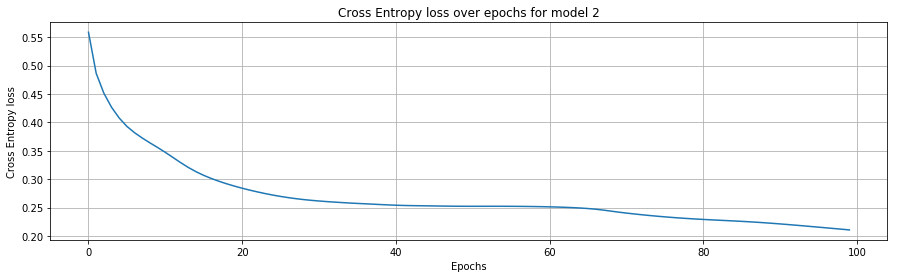

In [2]:
'Load the packages'

import h5py
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import timeit
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

'Import the data'

with h5py.File('train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('train_label.h5','r') as H:
    label = np.copy(H['label'])
with h5py.File('test_128.h5','r') as H:
    actual_test_data = np.copy(H['data'])
    
'Perform preprocessing' 

## Create a label list from the label array for prediction purposes
label_list = []
for i in label:
    label_list.append(i)

## Create a label matrix for computational purposes
label_matrix = []
for i in label:
    vect = [0]*10
    vect[i] = 1
    label_matrix.append(vect)
label_matrix = np.array(label_matrix)

## Train test split
train_data , test_data = data[:42000,:], data[42000:,:]
train_label, test_label = label_matrix[:42000], label_matrix[42000:]
    
'Activation Functions'

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, x):
        # a = np.tanh(x)   
        return 1.0 - x**2
    
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, x):
        return  x * (1 - x)
    
    def __relu(self, x):
        return x * (x > 0)
    
    def __relu_deriv(self, x):
        return 1 * (x > 0)
    
    def __leaky_relu(self, x, alpha=0.01):
        return alpha * -1 * x * (x < 0) + x * (x > 0)
    
    def __leaky_relu_deriv(self, x, alpha=0.01):
        return alpha * (x < 0) + 1 * (x > 0)
    
    def __softmax(self,x):
        e = np.exp(x-np.max(x))  # Stable softmax
        if e.ndim == 1:
            return e / np.sum(e, axis=0) # Number of dimensions 1
        else:  
            return e / np.array([np.sum(e, axis=1)]).T 
    
    def __softmax_deriv(self,x):
        e = np.exp(x-np.max(x)) 
        return e/np.sum(e) - (e/np.sum(e))**2
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'leaky_relu':
            self.f = self.__leaky_relu
            self.f_deriv = self.__leaky_relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv  

'Hidden Layer Class'

class HiddenLayer(object):    
    def __init__(self,n_in, n_out, W=None, b=None, rng = None,
                 activation='tanh'):

        self.input=None
        self.activation=Activation(activation).f
        self.activation_deriv=Activation(activation).f_deriv
        
        ## Initialize attentuation constant for momentum
        global gamma
        gamma = 0.9
        
        ## Rng check for dropout
        if rng is None:
            self.rng = np.random.RandomState(1234)
        
        ## Initialize weights and bias
        self.W = np.random.normal(0, 1 ,(n_in,n_out))
        self.b = np.zeros(n_out,)       
        
        if activation == 'logistic':
            self.W *= 4
    
        # Initialize gradients of W, b     
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # Initialize momentum values
        self.momentum_W = 0
        self.momentum_b = 0
        self.momentum_g = 0
        self.momentum_v = 0
        
        # This value checks to see that the initialization of the weight norm process occurs only once
        self.first_pass = 0
        
    def forward(self, input):
 
        # Calculate linear output of initial feedforward pass
        lin_output = np.dot(input, self.W) + self.b   
        
        # If initialization hasn't occurred, do so once
        if self.first_pass == 0:
            
            # Calculate standard deviation and mean 
            std_lin_output = np.std(lin_output)
            mean_lin_output = np.mean(lin_output)
            
            # Calculate g, v and b for initial pass
            self.g = 1/std_lin_output
            self.v = np.random.normal(0, 1, self.W.shape)   
            self.b = -mean_lin_output/std_lin_output
            
            self.first_pass += 1
        
        # Calculate the norm of v
        v_norm = np.linalg.norm(self.v)
        
        # Reconstruct W
        self.W = self.g*self.v/v_norm   
        
        # Calculate new linear output
        new_lin_output = np.dot(input, self.W) + self.b
        self.output = (
            new_lin_output if self.activation is None
            else self.activation(new_lin_output)
        )    
        
        # Pass these values to next layer
        self.input=input
        return self.output
    
    def backward(self, delta):
        
        # Calculate the new gradients using momentum update
        
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) + gamma * self.momentum_W
        self.grad_b = np.sum(delta, axis = 0) + gamma * self.momentum_b
        v_norm = np.linalg.norm(self.v)
        self.grad_g = self.grad_W * self.v / v_norm + gamma * self.momentum_g
        self.grad_v = self.g * self.grad_W/v_norm - self.g*self.grad_g * self.v/(v_norm)**2 + gamma * self.momentum_v
        delta_ = (delta.dot(self.W.T) * self.activation_deriv(self.input))
        
        # Return delta_ for next layer
        return delta_
        
    def dropout(self, input, prob_dropout):

        dropout_mask = self.rng.binomial(size=input.shape,n=1, p=1-prob_dropout)
        return dropout_mask
    
'Multi-Layer Perceptron'
 
## Create a container for dropout    
dropout_masks = []      
    
class MLP:
    
    def __init__(self, layers,p_dropout=0.5, rng = None, activation='tanh'):

        ### initialize layers
        self.layers=[]
        self.params=[]
        dropout_masks = []
        
        if rng is None:
            rng1 = np.random.RandomState(1234)
        
        self.activation=activation
        
        for i in range(len(layers)-1):
            # Hidden to Output
            if (i % len(layers) - 2) == 0:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation='tanh'))
            # Hidden to Hidden
            elif (i % len(layers) - 1) == 0:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation='tanh'))
            # Input to Hidden
            else:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation='tanh'))
            
    def forward(self,input, dropout = False, p_dropout = 0.5):
        for i in range(len(self.layers)):
            output=self.layers[i].forward(input)
            input=output
            if dropout == True and i < len(self.layers)-1:
                mask = self.layers[i].dropout(input = output, prob_dropout = p_dropout)
                output *= mask
                dropout_masks.append(mask)
                input=output
            self.output = output
        return output
    
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation).f_deriv
        error = (y-y_hat)
        
        ## Cross entropy loss
        m = 1/y.shape[0]      
        loss = -m * np.sum(y * np.log(np.absolute(y_hat)))
        
        ## divide by mini batch size
        delta= (error/30)
        return loss,delta      
            
    def backward(self,delta, dropout = False, p_dropout = 0.5):        
        for i in reversed(range(len(self.layers))):
            delta= self.layers[i].backward(delta)
            if dropout == True:
                if i > 0:
                    delta *= dropout_masks[i-1]
        del dropout_masks[:]
            
            
    def update(self,lr):
        for layer in self.layers:
            
            # Calculate new momentums of W, b, g and v and update each parameter
            layer.momentum_W = layer.momentum_W * gamma + lr * layer.grad_W
            layer.momentum_b = layer.momentum_b * gamma + lr * layer.grad_b
            layer.momentum_g = layer.momentum_g * gamma + lr * layer.grad_g
            layer.momentum_v = layer.momentum_v * gamma + lr * layer.grad_v
            layer.W += layer.momentum_W
            layer.b += layer.momentum_b
            layer.g += layer.momentum_g
            layer.v += layer.momentum_v

    def fit(self,X,y,learning_rate=0.1,dropout = False, p_dropout = 0.5, batchsize = 30, rng = None, epochs=100):
        
        # Mini-batch size
        num_of_batches = train_data.shape[0]/batchsize
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            
            shuffled_train, shuffled_label = shuffle(train_data, train_label, random_state = 1)
            
            bXY = zip(np.array_split(shuffled_train, num_of_batches, axis = 0),
                      np.array_split(shuffled_label, num_of_batches, axis = 0))
            
            loss=np.zeros(X.shape[0])
            for bX, bY in bXY:
                
                # forward pass
                b_y_hat = self.forward(bX)
                
                # backward pass
                loss,delta=self.criterion_MSE(bY,b_y_hat)
                self.backward(delta)
                
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x, dropout = False,p_dropout = 0.5):
        x = np.array(x)        
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = np.argmax(nn.forward(x[i,:],dropout = False))
        return output
    
'Training the neural network'

## Training the neural network
nn = MLP([128,64,32,10], activation = 'tanh')

## Start of function runtime
model2_start_time = timeit.default_timer()

## Build the model
MSE = nn.fit(train_data, train_label, learning_rate=0.01,dropout = False, epochs=100)
print('Cross Entropy Loss:%f'%MSE[-1])

## End of function runtime
model2_end_time = timeit.default_timer()

## Runtime difference
model2_time_dif = (model2_end_time - model2_start_time)/60

## Print the time difference
print('Function Runtime:', np.round(model2_time_dif, 2), 'minutes')

'Print Test Results'

## Calculating predictions and overall accuracy over testing data
output = nn.predict(test_data, dropout = False)
print("Accuracy over test data for model 2 is",np.mean(output == label_list[42000:]))

## Plotting cross entropy loss over epochs
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()
pl.title("Cross Entropy loss over epochs for model 2")
pl.xlabel("Epochs")
pl.ylabel("Cross Entropy loss")

## Precision, recall and F-score by class (classification report)
model2_report = classification_report(label_list[42000:], output)
print(model2_report)

## Creating a confusion matrix
confusion_targets = pd.Series(label_list[42000:], name='Targets')
confusion_preds = pd.Series(output, name='Predictions')
model2_confusion = pd.crosstab(confusion_targets, confusion_preds)
print(model2_confusion)

# Print Test Predictions from Test Data

In [ ]:
final_output = nn.predict(test_data, dropout = False)
final_labels = pd.DataFrame(final_output)
final_labels.to_csv('predicted_labels.csv')